# 1) Import Dependencies

In [24]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os

# 2) Loading in the Data

In [25]:
# Defining future parameters
IMAGE_SIZE = 100
BATCH_SIZE = 24
CHANNELS = 3
EPOCHS = 15
traindir = 'fruits360/fruits-360_dataset/fruits-360/Training'
testdir = 'fruits360/fruits-360_dataset/fruits-360/Test'

In [26]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
traindir, shuffle=True, image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 67692 files belonging to 131 classes.


In [27]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
testdir, shuffle=True, image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 22688 files belonging to 131 classes.


In [28]:
train_class_names = train_dataset.class_names
train_class_names

['Apple Braeburn',
 'Apple Crimson Snow',
 'Apple Golden 1',
 'Apple Golden 2',
 'Apple Golden 3',
 'Apple Granny Smith',
 'Apple Pink Lady',
 'Apple Red 1',
 'Apple Red 2',
 'Apple Red 3',
 'Apple Red Delicious',
 'Apple Red Yellow 1',
 'Apple Red Yellow 2',
 'Apricot',
 'Avocado',
 'Avocado ripe',
 'Banana',
 'Banana Lady Finger',
 'Banana Red',
 'Beetroot',
 'Blueberry',
 'Cactus fruit',
 'Cantaloupe 1',
 'Cantaloupe 2',
 'Carambula',
 'Cauliflower',
 'Cherry 1',
 'Cherry 2',
 'Cherry Rainier',
 'Cherry Wax Black',
 'Cherry Wax Red',
 'Cherry Wax Yellow',
 'Chestnut',
 'Clementine',
 'Cocos',
 'Corn',
 'Corn Husk',
 'Cucumber Ripe',
 'Cucumber Ripe 2',
 'Dates',
 'Eggplant',
 'Fig',
 'Ginger Root',
 'Granadilla',
 'Grape Blue',
 'Grape Pink',
 'Grape White',
 'Grape White 2',
 'Grape White 3',
 'Grape White 4',
 'Grapefruit Pink',
 'Grapefruit White',
 'Guava',
 'Hazelnut',
 'Huckleberry',
 'Kaki',
 'Kiwi',
 'Kohlrabi',
 'Kumquats',
 'Lemon',
 'Lemon Meyer',
 'Limes',
 'Lychee',
 'M

In [29]:
test_class_names = test_dataset.class_names
test_class_names

['Apple Braeburn',
 'Apple Crimson Snow',
 'Apple Golden 1',
 'Apple Golden 2',
 'Apple Golden 3',
 'Apple Granny Smith',
 'Apple Pink Lady',
 'Apple Red 1',
 'Apple Red 2',
 'Apple Red 3',
 'Apple Red Delicious',
 'Apple Red Yellow 1',
 'Apple Red Yellow 2',
 'Apricot',
 'Avocado',
 'Avocado ripe',
 'Banana',
 'Banana Lady Finger',
 'Banana Red',
 'Beetroot',
 'Blueberry',
 'Cactus fruit',
 'Cantaloupe 1',
 'Cantaloupe 2',
 'Carambula',
 'Cauliflower',
 'Cherry 1',
 'Cherry 2',
 'Cherry Rainier',
 'Cherry Wax Black',
 'Cherry Wax Red',
 'Cherry Wax Yellow',
 'Chestnut',
 'Clementine',
 'Cocos',
 'Corn',
 'Corn Husk',
 'Cucumber Ripe',
 'Cucumber Ripe 2',
 'Dates',
 'Eggplant',
 'Fig',
 'Ginger Root',
 'Granadilla',
 'Grape Blue',
 'Grape Pink',
 'Grape White',
 'Grape White 2',
 'Grape White 3',
 'Grape White 4',
 'Grapefruit Pink',
 'Grapefruit White',
 'Guava',
 'Hazelnut',
 'Huckleberry',
 'Kaki',
 'Kiwi',
 'Kohlrabi',
 'Kumquats',
 'Lemon',
 'Lemon Meyer',
 'Limes',
 'Lychee',
 'M

In [30]:
len(train_dataset)

2821

In [31]:
for image_batch, label_batch in train_dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy)

(24, 100, 100, 3)
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(24,), dtype=int32, numpy=
array([ 85,  25,  34,  47, 101,   7,   0,  90,  95,  82,  33,  33,  95,
       118, 126,  84,   4,  46,   8,  30,  89,  27,  95, 105])>>


# 3) Data Visualization

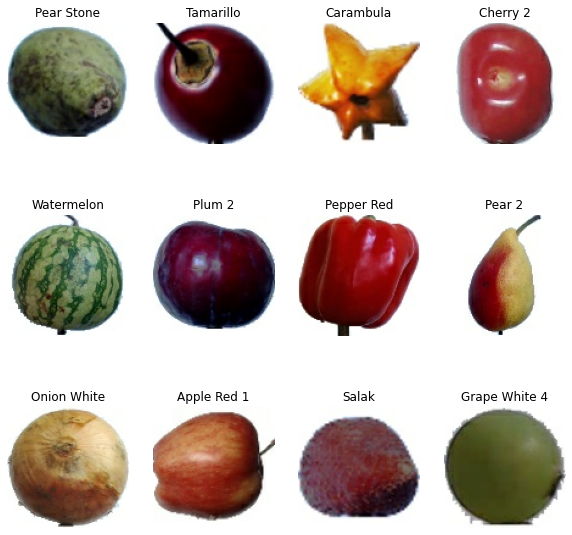

In [32]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8')) # expects a 3D array, 
        plt.title(train_class_names[label_batch[i]])
        plt.axis('off')

In [33]:
val_size = int(len(test_dataset)/2) # equal to 473
val_data = test_dataset.take(473)
test_data = test_dataset.skip(473)

In [34]:
len(test_data)

473

# 4) Data Preprocessing

In [35]:
# Tips to improve performance of tensorflow:
    # cache() = the first time the dataset is iterated over, its elements will be cached either in the specified file or in memory.
    # Subsequent iterations will use the cached data
    # prefetch() = load the next set of batch from disk
    
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 
val_data = val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [36]:
# Creating layers for Scaling and resizing the images
# resizing is used just in case an image that is not 256x256 is inputted to keep the images uniform

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/100)
])

In [37]:
# WARNING: using RandomFlip and RandomRotation (along with 2 others) prevents the model from being saved
# in a tf.serving format and can only be saved in a h5 format
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

# 5) Model Building

In [43]:
input_shape=(BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
n_classes = 131

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
#     layers.Conv2D(64, (3,3), activation='relu'),
#     layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [40]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 49, 49, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 21, 21, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 10, 10, 64)      

In [41]:
# Compiling the model

model.compile(
optimizer='adam',
loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy']
)

In [42]:
# Train the model

history = model.fit(train_dataset, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_data=val_data)

Epoch 1/15


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential_5/conv2d_4/Relu
 (defined at C:\Users\jjdun\anaconda3\lib\site-packages\keras\backend.py:4867)
]] [Op:__inference_train_function_3180]

Errors may have originated from an input operation.
Input Source operations connected to node sequential_5/conv2d_4/Relu:
In[0] sequential_5/conv2d_4/BiasAdd (defined at C:\Users\jjdun\anaconda3\lib\site-packages\keras\layers\convolutional.py:264)

Operation defined at: (most recent call last)
>>>   File "C:\Users\jjdun\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
>>>     app.start()
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
>>>     self.io_loop.start()
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\asyncio\base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\asyncio\base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\asyncio\events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\tornado\ioloop.py", line 688, in <lambda>
>>>     lambda f: self._run_callback(functools.partial(callback, future))
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\tornado\ioloop.py", line 741, in _run_callback
>>>     ret = callback()
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\tornado\gen.py", line 814, in inner
>>>     self.ctx_run(self.run)
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\tornado\gen.py", line 775, in run
>>>     yielded = self.gen.send(value)
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 365, in process_one
>>>     yield gen.maybe_future(dispatch(*args))
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\tornado\gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
>>>     yield gen.maybe_future(handler(stream, idents, msg))
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\tornado\gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 543, in execute_request
>>>     self.do_execute(
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\tornado\gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 306, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2894, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3165, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3357, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "<ipython-input-42-0e22bb901ac5>", line 1, in <module>
>>>     history = model.fit(train_dataset, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_data=val_data)
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\keras\engine\training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\keras\engine\training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\keras\engine\training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\keras\engine\training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\keras\engine\training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\keras\engine\sequential.py", line 373, in call
>>>     return super(Sequential, self).call(inputs, training=training, mask=mask)
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\keras\engine\functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\keras\layers\convolutional.py", line 273, in call
>>>     return self.activation(outputs)
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\keras\activations.py", line 311, in relu
>>>     return backend.relu(x, alpha=alpha, max_value=max_value, threshold=threshold)
>>> 
>>>   File "C:\Users\jjdun\anaconda3\lib\site-packages\keras\backend.py", line 4867, in relu
>>>     x = tf.nn.relu(x)
>>> 

In [50]:
# Testing the model

scores = model.evaluate(test_data)

473/473 [==============================] - 11s 7ms/step - loss: 0.4494 - accuracy: 0.9462


In [51]:
history.history['accuracy']

[0.7938899993896484,
 0.969508945941925,
 0.9793328642845154,
 0.984178364276886,
 0.9877976775169373,
 0.9892158508300781,
 0.989526093006134,
 0.9923181533813477,
 0.9923920035362244,
 0.9916386008262634,
 0.9925397634506226,
 0.9925249814987183,
 0.9932783842086792,
 0.9941499829292297,
 0.9928795099258423]

Text(0.5, 1.0, 'Training and Validation Accuracy')

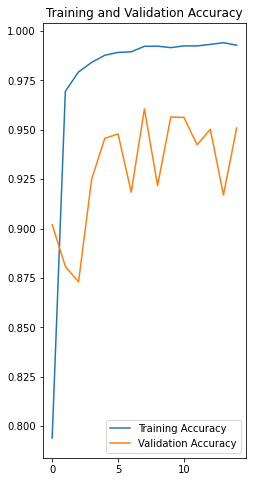

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

first image to predict
actual label: Granadilla
Predicted label Granadilla


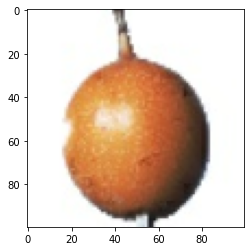

In [58]:
for images_batch, labels_batch in test_data.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label =labels_batch[0].numpy()
    
    print('first image to predict')
    plt.imshow(first_image)
    print('actual label:', class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print('Predicted label', class_names[np.argmax(batch_prediction[0])])

In [59]:
model_version = 1
model.save(f'models/{model_version}')

INFO:tensorflow:Assets written to: models/1\assets
